In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import contractions
import csv
import gensim

#from tqdm import tqdm
from tqdm import notebook as tq
import multiprocessing
cores = multiprocessing.cpu_count()

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from bs4 import BeautifulSoup
from textblob import TextBlob, Word

from torch.autograd import Variable
import torch.nn.functional as F
import torch

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import word2vec

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.utils import resample  # Upsampling
from sklearn.ensemble import HistGradientBoostingClassifier  # LightGBM
from sklearn.model_selection import GridSearchCV  # Hyperparameter Tuning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.datasets import make_imbalance

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import utils

import warnings
warnings.filterwarnings('ignore')

#### Serveral of the codes in this project are an inspiration, transfortation or a copy from the following sources online:
* https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34
* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
* https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99
* https://medium.com/@morga046/multi-class-text-classification-with-doc2vec-and-t-sne-a-full-tutorial-55eb24fc40d3
* https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d

In [2]:
class Sentiment:
    def __init__(self, tags):
        self.result = []
        self.tags = tags
        
    def loaddataset(self, train_file, test_file=None):
        ## load data
        train = pd.read_csv(f'data/{train_file}', sep = '\t')
        train['sets'] = 'train'

        if test_file is not None:
            val = pd.read_csv(f'data/{test_file}', sep = '\t')
            val['sets'] = 'test'
        else:
            val = []
        
        return train.append(val).reset_index()
    
    def splitdataset(self, dataset):
        
        _train = dataset[dataset.sets == 'train']
        df_test = dataset[dataset.sets == 'test']
        
        df_train = _train.groupby('emotion')['clean_sentence'].apply(lambda s: s.sample(1000)).reset_index()
        
        # Train
        X_train = df_train.clean_sentence
        y_train = df_train.emotion

        # Test
        X_test = df_test.clean_sentence
        y_test = df_test.emotion
        
        return X_train, y_train, X_test, y_test
    
    def normalise_sentence(self, dataset):

        clean_sentence = []
        
        for row in dataset.sentence:
            
            # Tagging exclamaction, question and period at the end of the sentence
                        
            if row.endswith("!"):
                sentence = re.sub(r".$", "[endexclamation]", row)
            elif row.endswith("."):
                sentence = re.sub(r".$", "[endperiod]", row)
            elif row.endswith("?"):
                sentence = re.sub(r".$", "[endquestion]", row)
            else:
                sentence = row
                
            
            # Remove tags
            sentence = BeautifulSoup(sentence).get_text()

            sentence = self.decontracted(f"{sentence}")

            # Lemmatize words
            s = TextBlob(sentence)                               
            sentence = " ".join([w.lemmatize() for w in s.words])

            # Lower words
            sentence = sentence.lower() 
            sentence = self.remove_mystopwords(sentence)
            clean_sentence.append(sentence)
            
        
        dataset['clean_sentence'] = clean_sentence
        return dataset
        
    def decontracted(self,phrase):
        # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
        
    def remove_mystopwords(self, sentence):
        my_stopwords = stopwords.words('english')
        newStopWords = ('wa')
        my_stopwords.extend(newStopWords)
        text_tokens = word_tokenize(sentence)
        
        #tokens = sentence.split(" ")
        tokens_filtered= [word for word in text_tokens if not word in my_stopwords]
        return (" ").join(tokens_filtered)
    
    def plot_distribution(self, df):
        # Filtering only the train dataset and excluding the test dataset
        
        fig = plt.figure(figsize=(8,6))
        df.groupby('emotion').sentence.count().plot.bar(ylim=0)
        plt.xlabel("Type of emotions")
        plt.ylabel("No. of sentences")
        plt.title(f"Sentence per emotions in Training set")
        plt.show()
    
    def tokenize_sentence(self, dataset):
        tokens, length= [], []
        for word in dataset.clean_sentence:
            tokens.append(word.split())
            length.append(len(word.split()))
        dataset['tokens'] = tokens
        dataset['length'] = length
        return dataset
    
    def predict(self, m, X_test, y_test, name=None):
        y_pred = m.predict(X_test)

        print('accuracy %s' % accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred,target_names=self.tags))
        self.heatconmat(y_test, y_pred)
        
        self.result.append({'model':name, 
                            'accuracy':accuracy_score(y_test, y_pred), 
                            'f1_score':f1_score(y_test, y_pred, average='weighted')}
                          )
    
    def text_predict(self, m, dataset):
        
        prediction = []
        # Data transformation pipeline

        y_pred = m.predict(dataset)
        
        tags = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
        
        for i, sentence in tq.tqdm(enumerate(dataset)):
            prediction.append({'sentence':sentence,
                             'emotion': y_pred[i],
                              'definition':tags[int(y_pred[i])-1]})
        
        return pd.DataFrame(prediction)
        
    def heatconmat(self, y_true, y_pred):
        plt.figure(figsize=(9,6))
        sns.heatmap(confusion_matrix(y_true,y_pred),
                    annot=True,
                    fmt='d',
                    cbar=False,
                    cmap='gist_earth_r',
                    #yticklabels=list(set(y_test)),
                    xticklabels=self.tags, 
                    yticklabels=self.tags)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title("CONFUSION MATRIX", size=16);
        plt.show()
        
    def confusion_mx(self, y_true, y_pred):
        conf_mat = confusion_matrix(y_true, y_pred)
        fig, ax = plt.subplots(figsize=(8,8))
        sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
                    xticklabels=self.tags, 
                    yticklabels=self.tags)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title("CONFUSION MATRIX", size=16);

In [3]:
class Model:
    
    def __init__(self):
        self.name = None
        self.accuracy = None
        self.f1 = None
        self.report = None
    
    def knn(self, X_train, y_train, n=3, algorithm='auto', p=2, weights='uniform'):
        
        #KNN classifier
        knn = Pipeline([('vect', CountVectorizer()),
                        ('knn', KNeighborsClassifier(n_neighbors=n, algorithm=algorithm, p=p, weights=weights)),
                       ])
        model = knn.fit(X_train, y_train)
        return model
    
    def svc(self, X_train, y_train, C=1.0, kernel='poly', degree=3, gamma='auto'):
        
        
        svc = Pipeline([('vect', CountVectorizer()),
                ('svm', SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)),
               ])
        model = svc.fit(X_train, y_train)
        return model
    
    def logr(self, X_train, y_train, C=15, multi_class='multinomial', solver='saga',max_iter=1000):
        
        X_train, y_train, X_test, y_test = self.splitdataset()
        
        logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=15, multi_class=multi_class, 
                                           solver=solver, max_iter=max_iter)),
               ])
        model = logreg.fit(X_train, y_train)
        return model

    def mnnb(self, X_train, y_train, alpha=1.0, fit_prior=True, class_prior=None):
        
        
        nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha=alpha, fit_prior=fit_prior, class_prior=class_prior)),
              ])

        model = nb.fit(X_train, y_train)
        return model
    
    def sgdc(self, X_train, y_train, loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None):
        
        sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss=loss, penalty=penalty,alpha=alpha, random_state=random_state, 
                                      max_iter=max_iter, tol=tol)),
               ])
        model = sgd.fit(X_train, y_train)
        return model

In [4]:
class DocVec:
    
    def __init__(self):
        self.dataset = None
        
    def tagdata(self, dataset):
        #Split data using the sets name

        # Preparing the the data by tagging the documents
        _tagged = dataset.apply(lambda t: TaggedDocument(words=self.tokenize_text(t['clean_sentence']), 
                                      tags=[t.emotion]), axis=1)
        
        return _tagged
        
    def createmodel(self, 
                    vector_size=100,
                    window=5, 
                    alpha=0.065, 
                    min_alpha=0.00025, 
                    min_count=2, 
                    dm=1,
                    negative=5,):
        
        cores = multiprocessing.cpu_count()
        # Creating a model
        
        model = Doc2Vec(vector_size=vector_size,
                        window=window, 
                        alpha=alpha, 
                        min_alpha=min_alpha, 
                        min_count=min_count, 
                        dm=dm, 
                        workers=cores)
        self.model = model
        
    def trainmodel(self, train_tagged):
        self.model.build_vocab([x for x in train_tagged.values])
        
        for epoch in range(100):
            self.model.train(utils.shuffle([x for x in tq.tqdm(train_tagged.values)]), 
                        total_examples=len(train_tagged.values), epochs=1)
            self.model.alpha -= 0.002
            self.model.min_alpha = self.model.alpha
            self.model.save('sentiment.model')
    
    def tokenize_text(self, text):
        tokens = []
        for sent in nltk.sent_tokenize(text):
            for word in nltk.word_tokenize(sent):
                if len(word) < 2:
                    continue
                tokens.append(word)
        return tokens

    def vec_for_learning(self, tagged_docs):
        
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], self.model.infer_vector(doc.words)) for doc in sents])
        return targets, regressors

    def splitdataset(self, tagged_docs):
        
        _y, _X = self.vec_for_learning(train_tagged)
        
        return _X, _y

    def logr(self, X_train, y_train, C=15, multi_class='multinomial', solver='saga',max_iter=5000):
    
        logreg = LogisticRegression(C=15, multi_class=multi_class, solver=solver, max_iter=max_iter)
        model = logreg.fit(X_train, y_train)
        return model
    
    def mlp(self, X_train, y_train, hidden_layer_sizes=(10, 10, 10)):
        
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)
        model = mlp.fit(X_train, y_train)
        return model
    
    def svc(self, X_train, y_train, C=1.0, kernel='linear', degree=3, gamma='auto'):
        
        scv = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
        # Train the model on training data
        model =scv.fit(X_train, y_train)
        
        return model
    
    def rf(self, X_train, y_train):
        
        # Random Forest Classifier
        rfcmodel = rfc(bootstrap=True, 
            criterion='gini',
            max_features='auto', 
            max_leaf_nodes=30,
            min_impurity_decrease=0.00002,
            min_samples_leaf=1, 
            min_samples_split=2,
            min_weight_fraction_leaf=0.0001, 
            n_estimators=300, 
            n_jobs=2,
            random_state=20, verbose=0)
        # Train the model on training data
        model = rfcmodel.fit(X_train, y_train);

        return model

In [5]:
class WordVec:
    
    def __init__(self):
        self.model = None

    def tokenize_corpus(self, sentences):
        tokenize_sentences = []

        for i, sentence in enumerate(sentences):
            tokenize_sentences.append(nltk.word_tokenize(gensim.utils.to_unicode(sentence.lower())))
            
        return tokenize_sentences
        
    def createmodel(self, tokenize_sentences,
                    sg= 1,
                    num_features = 300, 
                    min_word_count = 5, 
                    num_workers = multiprocessing.cpu_count(), 
                    context = 10, 
                    downsampling = 1e-3,):
        
        mwv = word2vec.Word2Vec(tokenize_sentences,
                        sg= sg,
                        vector_size = num_features, 
                        min_count = min_word_count, 
                        workers = multiprocessing.cpu_count(), 
                        sorted_vocab=1,
                        max_vocab_size=None,
                        window = context, 
                        sample = downsampling)
        
        self.model = mwv
        # Saving the model for later use. Can be loaded using Word2Vec.load()
        model_name = "word2vec_40minwords_10context"
        mwv.save(model_name)
    
    def w2v_tokenize_text(self,text):
        tokens = []
        for sent in nltk.sent_tokenize(text, language='english'):
            for word in nltk.word_tokenize(sent, language='english'):
                if len(word) < 2:
                    continue
                tokens.append(word)
        return tokens
    
    def tokenize_text(self, sentence):
        _tokenized = sentence.apply(lambda t: self.w2v_tokenize_text(t['clean_sentence']), axis=1).values
        
        return _tokenized

    def word_averaging(self, words):
        mean = []

        vocab = np.array(self.model.wv.index_to_key)
        vectors = np.array(self.model.wv.vectors.tolist())

        for word in words:
            if isinstance(word, np.ndarray):
                mean.append(word)
            elif word in vocab:
                mean.append(vectors[np.where(vocab==word)])

        if not mean:
            return np.zeros(self.model.wv.vector_size,)  

        final_mean = gensim.matutils.unitvec(np.array(mean, dtype=object).mean(axis=0)).astype(np.float32)
        return final_mean
    
    def word_averaging_list(self, tokenized_text):
        return np.vstack([self.word_averaging(post) for post in tq.tqdm(tokenized_text)])
    
    def x_average(self, tokenized_sentence):

        X_word_average = self.word_averaging_list(tokenized_sentence)
        
        return X_word_average

    def adb(self, X_train, y_train, max_depth=21, n_estimators=30, learning_rate=0.25):
         
    
        DTC=DecisionTreeClassifier(max_depth=max_depth)
        adb = AdaBoostClassifier(n_estimators=n_estimators, base_estimator=DTC ,learning_rate=learning_rate)

        # Creating the model on Training Data
        model = adb.fit(X_train, y_train)
        return model
    
    def hsgb(self, X_train, y_train, learning_rate=0.19, max_leaf_nodes=50, max_iter=65, random_state=23):
        
        hsgb = HistGradientBoostingClassifier(learning_rate=learning_rate, 
                                              max_leaf_nodes=max_leaf_nodes, 
                                              max_iter=max_iter, 
                                              random_state=random_state)
        model = hsgb.fit(X_train, y_train)
        return model
    
    def knnc(self, X_train, y_train, n_neighbors=8):
        
        knnc = KNeighborsClassifier(n_neighbors=n_neighbors)

        # Train the model on training data
        model = knnc.fit(X_train, y_train)
        return model
    
    def rf(self, X_train, y_train, n_estimators = 200, random_state=20):
        
        # Random Forest Classifier
        rfcmodel = rfc(n_estimators = n_estimators, random_state=random_state)
        # Train the model on training data
        model = rfcmodel.fit(X_train, y_train);

        return model
    
    def svc(self, X_train, y_train, C=1.0, kernel='sigmoid', degree=3, gamma='auto'):
        
        scv = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
        # Train the model on training data
        model =scv.fit(X_train, y_train)
        
        return model

In [6]:
# Iinitialize sentiment data
tags = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
data = Sentiment(tags)
dataset_df = data.loaddataset('training_set.txt', 'dev_set.txt')

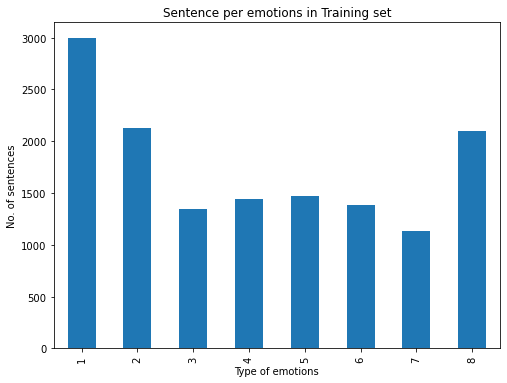

In [7]:
# Data transformation pipeline
dataset_df = data.normalise_sentence(dataset_df)
data.plot_distribution(dataset_df[dataset_df['sets'] == 'train'])
dataset_df = data.tokenize_sentence(dataset_df)

In [8]:
# Print top 5 of the dataset
dataset_df.head()

,index,sentence,emotion,sets,clean_sentence,tokens,length
0,0,I'm too old to be traded in .,6,train,old traded endperiod,"[old, traded, endperiod]",3
1,1,Mother said you could always tell a lady by he...,8,train,mother said could always tell lady hand endperiod,"[mother, said, could, always, tell, lady, hand...",8
2,2,I always said I'd leave off when the time came .,6,train,always said would leave time came endperiod,"[always, said, would, leave, time, came, endpe...",7
3,3,He'll be safe with me .,2,train,safe endperiod,"[safe, endperiod]",2
4,4,Lay off .,1,train,lay endperiod,"[lay, endperiod]",2


### Initialise the train and test data to the model

In [9]:
# Slicing the dataset preparing to load in the model
df = dataset_df[['clean_sentence', 'sets','emotion']]

In [10]:
# Loading the dataset to the model for initialisation
model = Model()

### Split data for X_train, y_train, X_test, y_test

In [11]:
# Split dataset
X_train, y_train, X_test, y_test = data.splitdataset(df)

### For CountVectorizer + KNN (accuracy score to beat 27%)

accuracy 0.257
              precision    recall  f1-score   support

       Anger       0.24      0.73      0.36       211
Anticipation       0.28      0.26      0.27       170
     Disgust       0.12      0.08      0.10        77
        Fear       0.28      0.12      0.17       104
         Joy       0.38      0.22      0.28        97
     Sadness       0.12      0.02      0.04        87
    Surprise       0.39      0.07      0.12        96
       Trust       0.60      0.06      0.10       158

    accuracy                           0.26      1000
   macro avg       0.30      0.20      0.18      1000
weighted avg       0.32      0.26      0.21      1000



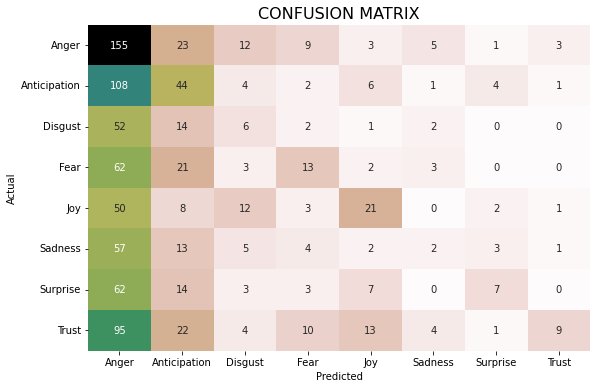

In [12]:
knnmodel = model.knn(X_train, y_train)
data.predict(knnmodel, X_test, y_test,'knn')

### For CountVectorizer + SVC (accuracy score to beat 34%)

accuracy 0.192
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00       211
Anticipation       0.17      0.66      0.27       170
     Disgust       0.00      0.00      0.00        77
        Fear       0.00      0.00      0.00       104
         Joy       0.26      0.43      0.33        97
     Sadness       0.00      0.00      0.00        87
    Surprise       0.20      0.40      0.27        96
       Trust       0.00      0.00      0.00       158

    accuracy                           0.19      1000
   macro avg       0.08      0.19      0.11      1000
weighted avg       0.07      0.19      0.10      1000



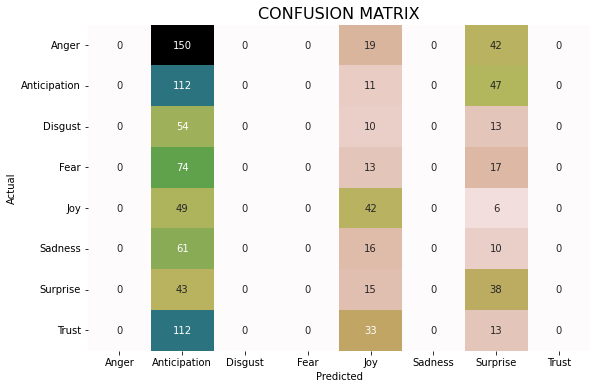

In [13]:
svcmodelp = model.svc(X_train, y_train, kernel='poly')
data.predict(svcmodelp, X_test, y_test,'svm poly')

accuracy 0.32
              precision    recall  f1-score   support

       Anger       0.34      0.26      0.30       211
Anticipation       0.43      0.35      0.38       170
     Disgust       0.22      0.25      0.23        77
        Fear       0.33      0.34      0.33       104
         Joy       0.38      0.46      0.42        97
     Sadness       0.23      0.29      0.26        87
    Surprise       0.27      0.43      0.33        96
       Trust       0.31      0.26      0.28       158

    accuracy                           0.32      1000
   macro avg       0.31      0.33      0.32      1000
weighted avg       0.33      0.32      0.32      1000



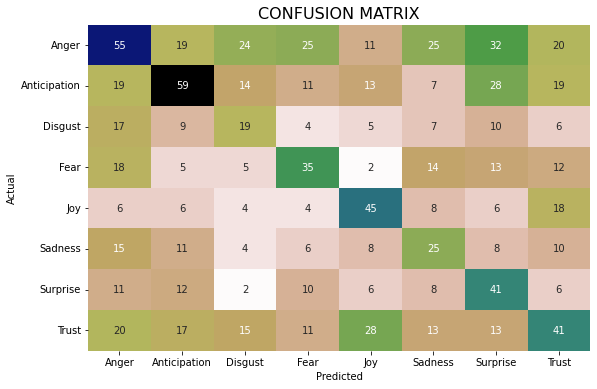

In [14]:
svcmodell = model.svc(X_train, y_train, kernel='linear')
data.predict(svcmodell, X_test, y_test,'svm ln')

accuracy 0.224
              precision    recall  f1-score   support

       Anger       0.37      0.23      0.28       211
Anticipation       0.00      0.00      0.00       170
     Disgust       0.00      0.00      0.00        77
        Fear       0.00      0.00      0.00       104
         Joy       0.44      0.04      0.08        97
     Sadness       0.25      0.11      0.16        87
    Surprise       0.20      0.39      0.26        96
       Trust       0.20      0.79      0.32       158

    accuracy                           0.22      1000
   macro avg       0.18      0.20      0.14      1000
weighted avg       0.19      0.22      0.16      1000



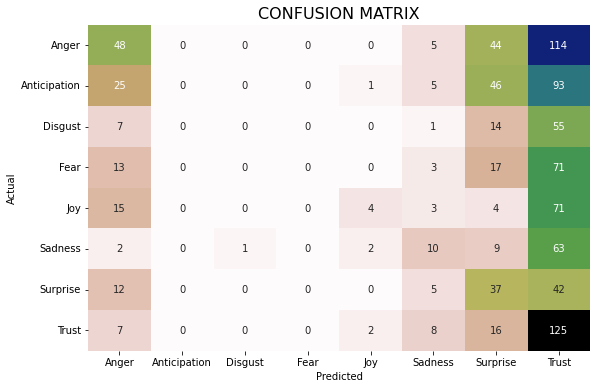

In [15]:
svcmodelr = model.svc(X_train, y_train, kernel='rbf')
data.predict(svcmodelr, X_test, y_test,'svm rbf')

accuracy 0.225
              precision    recall  f1-score   support

       Anger       0.37      0.23      0.28       211
Anticipation       0.00      0.00      0.00       170
     Disgust       0.00      0.00      0.00        77
        Fear       0.00      0.00      0.00       104
         Joy       0.44      0.04      0.08        97
     Sadness       0.27      0.13      0.17        87
    Surprise       0.20      0.39      0.26        96
       Trust       0.20      0.79      0.32       158

    accuracy                           0.23      1000
   macro avg       0.19      0.20      0.14      1000
weighted avg       0.20      0.23      0.16      1000



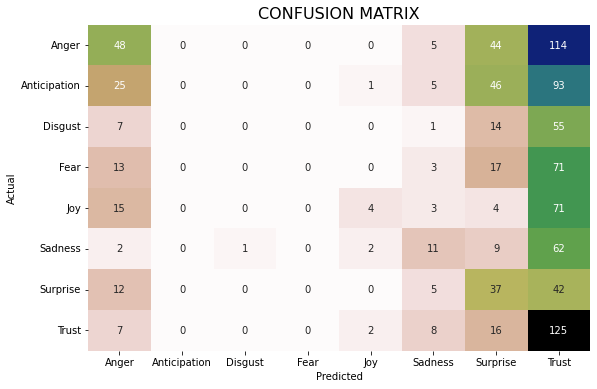

In [16]:
svcmodels = model.svc(X_train, y_train, kernel='sigmoid')
data.predict(svcmodels, X_test, y_test,'svm sigmoid')

### For SGD with Tfidf in the pipeline

accuracy 0.288
              precision    recall  f1-score   support

       Anger       0.42      0.27      0.33       211
Anticipation       0.30      0.23      0.26       170
     Disgust       0.17      0.23      0.20        77
        Fear       0.33      0.35      0.34       104
         Joy       0.29      0.53      0.37        97
     Sadness       0.25      0.29      0.27        87
    Surprise       0.24      0.40      0.30        96
       Trust       0.29      0.15      0.20       158

    accuracy                           0.29      1000
   macro avg       0.29      0.31      0.28      1000
weighted avg       0.31      0.29      0.28      1000



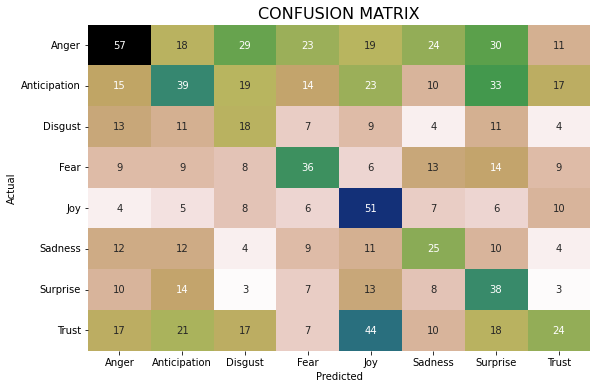

In [17]:
sgdmodel = model.sgdc(X_train, y_train)
data.predict(sgdmodel, X_test, y_test,'sgd')

### Doc2Vec

In [18]:
# Initialising Doc2Vec class
dtov = DocVec()
#Tag Dataset
_train = df[df.sets == 'train']
df_test = df[df.sets == 'test']

# Getting a balance sample
df_train = _train.groupby('emotion')['clean_sentence'].apply(lambda s: s.sample(1000)).reset_index()

train_tagged = dtov.tagdata(df_train)
test_tagged = dtov.tagdata(df_test)

dtov.createmodel(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)

dtov.trainmodel(train_tagged)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [19]:
#Split data tagged dataset using the sets name
X_train_d2v, y_train_d2v = dtov.splitdataset(train_tagged)

X_test_d2v, y_test_d2v = dtov.splitdataset(test_tagged)

accuracy 0.2605
              precision    recall  f1-score   support

       Anger       0.26      0.22      0.24      1000
Anticipation       0.25      0.21      0.23      1000
     Disgust       0.30      0.23      0.26      1000
        Fear       0.26      0.26      0.26      1000
         Joy       0.28      0.37      0.32      1000
     Sadness       0.27      0.19      0.22      1000
    Surprise       0.24      0.38      0.30      1000
       Trust       0.24      0.23      0.23      1000

    accuracy                           0.26      8000
   macro avg       0.26      0.26      0.26      8000
weighted avg       0.26      0.26      0.26      8000



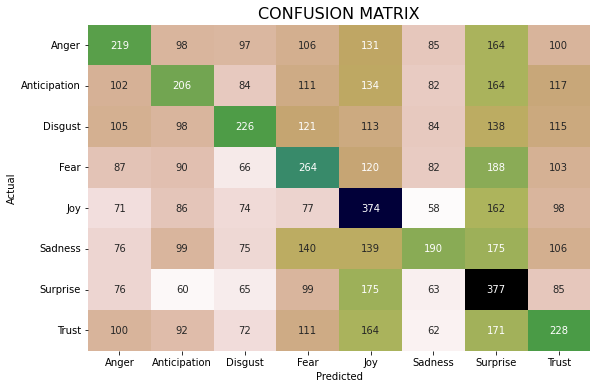

In [20]:
# Create a Logistic Regression Classifier
logrmodel = dtov.logr(X_train=X_train_d2v, y_train=y_train_d2v)
data.predict(logrmodel, X_test_d2v, y_test_d2v, name='NB dv')

accuracy 0.235625
              precision    recall  f1-score   support

       Anger       0.18      0.12      0.15      1000
Anticipation       0.19      0.18      0.19      1000
     Disgust       0.25      0.35      0.29      1000
        Fear       0.22      0.27      0.24      1000
         Joy       0.30      0.32      0.31      1000
     Sadness       0.25      0.25      0.25      1000
    Surprise       0.24      0.36      0.29      1000
       Trust       0.17      0.03      0.05      1000

    accuracy                           0.24      8000
   macro avg       0.23      0.24      0.22      8000
weighted avg       0.23      0.24      0.22      8000



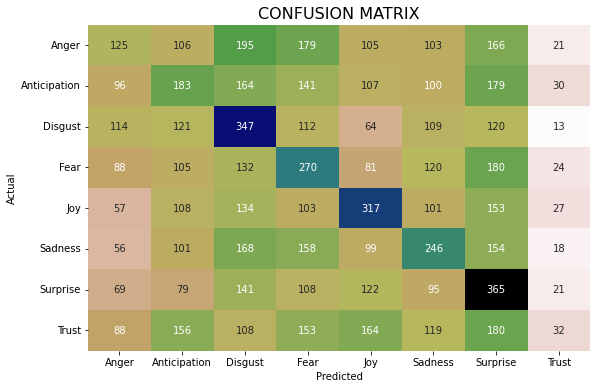

In [21]:
# Create a MLP Classifier
mlpmodel = dtov.mlp(X_train=X_train_d2v, y_train=y_train_d2v)
data.predict(mlpmodel, X_test_d2v, y_test_d2v, name='mlp dv')

accuracy 0.253625
              precision    recall  f1-score   support

       Anger       0.27      0.18      0.21      1000
Anticipation       0.26      0.16      0.20      1000
     Disgust       0.23      0.41      0.30      1000
        Fear       0.24      0.23      0.23      1000
         Joy       0.28      0.35      0.31      1000
     Sadness       0.26      0.23      0.24      1000
    Surprise       0.25      0.34      0.29      1000
       Trust       0.27      0.13      0.17      1000

    accuracy                           0.25      8000
   macro avg       0.26      0.25      0.24      8000
weighted avg       0.26      0.25      0.24      8000



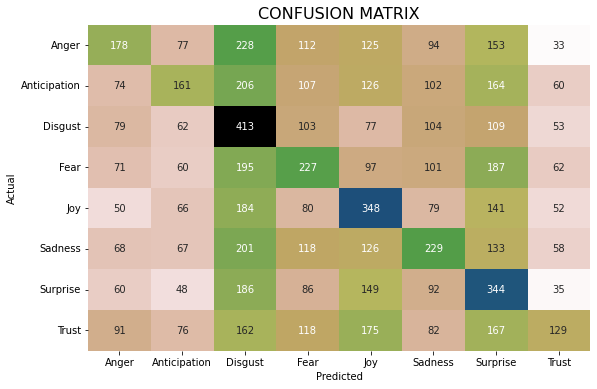

In [22]:
#Create a RFC Classifier
rfmodel = dtov.rf(X_train=X_train_d2v, y_train=y_train_d2v)
data.predict(rfmodel, X_test_d2v, y_test_d2v, name='rfc dv')

accuracy 0.2545
              precision    recall  f1-score   support

       Anger       0.25      0.19      0.22      1000
Anticipation       0.23      0.21      0.22      1000
     Disgust       0.29      0.25      0.27      1000
        Fear       0.25      0.25      0.25      1000
         Joy       0.28      0.34      0.31      1000
     Sadness       0.27      0.16      0.20      1000
    Surprise       0.23      0.44      0.30      1000
       Trust       0.25      0.19      0.22      1000

    accuracy                           0.25      8000
   macro avg       0.26      0.25      0.25      8000
weighted avg       0.26      0.25      0.25      8000



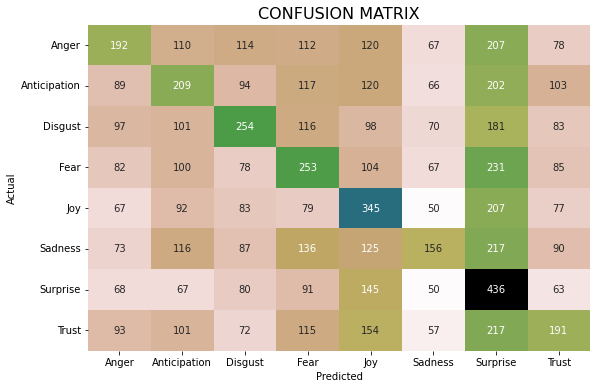

In [23]:
svcl = dtov.svc(X_train=X_train_d2v, y_train=y_train_d2v, kernel='linear')
data.predict(svcl, X_test_d2v, y_test_d2v, 'svm dv ln')

accuracy 0.128125
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00      1000
Anticipation       0.11      0.00      0.00      1000
     Disgust       0.27      0.03      0.06      1000
        Fear       0.00      0.00      0.00      1000
         Joy       0.14      0.00      0.01      1000
     Sadness       0.00      0.00      0.00      1000
    Surprise       0.13      0.99      0.22      1000
       Trust       0.00      0.00      0.00      1000

    accuracy                           0.13      8000
   macro avg       0.08      0.13      0.04      8000
weighted avg       0.08      0.13      0.04      8000



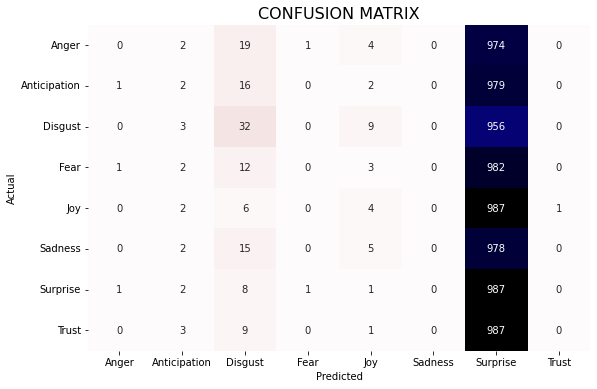

In [24]:
svcp = dtov.svc(X_train=X_train_d2v, y_train=y_train_d2v, kernel='poly')
data.predict(svcp, X_test_d2v, y_test_d2v,'svm dv pl')

accuracy 0.15475
              precision    recall  f1-score   support

       Anger       0.25      0.00      0.00      1000
Anticipation       0.28      0.01      0.03      1000
     Disgust       0.22      0.30      0.25      1000
        Fear       0.24      0.02      0.04      1000
         Joy       0.17      0.05      0.07      1000
     Sadness       0.56      0.01      0.01      1000
    Surprise       0.14      0.85      0.24      1000
       Trust       0.12      0.00      0.00      1000

    accuracy                           0.15      8000
   macro avg       0.25      0.15      0.08      8000
weighted avg       0.25      0.15      0.08      8000



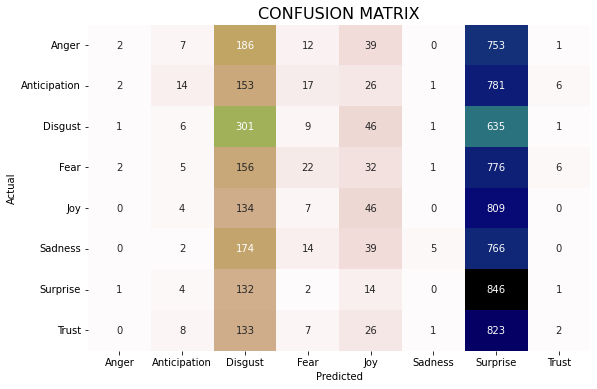

In [25]:
svcr = dtov.svc(X_train=X_train_d2v, y_train=y_train_d2v, kernel='rbf')
data.predict(svcr, X_test_d2v, y_test_d2v,'svm dv rb')

accuracy 0.14675
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00      1000
Anticipation       0.29      0.00      0.00      1000
     Disgust       0.22      0.25      0.24      1000
        Fear       0.36      0.01      0.02      1000
         Joy       0.15      0.04      0.06      1000
     Sadness       0.00      0.00      0.00      1000
    Surprise       0.13      0.88      0.23      1000
       Trust       0.00      0.00      0.00      1000

    accuracy                           0.15      8000
   macro avg       0.14      0.15      0.07      8000
weighted avg       0.14      0.15      0.07      8000



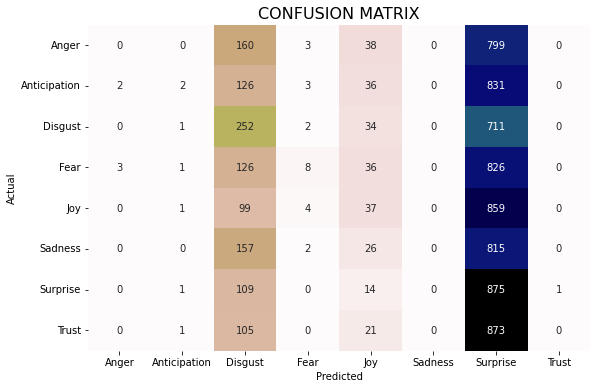

In [26]:
svcs = dtov.svc(X_train=X_train_d2v, y_train=y_train_d2v, kernel='sigmoid')
data.predict(svcs, X_test_d2v, y_test_d2v,'svm dv sigmoid')

### Word2Vec

In [27]:
# Initialising Doc2Vec class
wvmodel = WordVec()

In [28]:
# Tokenise corpus sentences
tokenise_sentences = wvmodel.tokenize_corpus(df.clean_sentence)

In [29]:
# Creating the model
wvmodel.createmodel(tokenise_sentences)

In [30]:
_train = df[df.sets == 'train']
df_test = df[df.sets == 'test']

# Getting a balance sample
df_train = _train.groupby('emotion')['clean_sentence'].apply(lambda s: s.sample(1000)).reset_index()

train_tokenzied = wvmodel.tokenize_text(df_train)
test_tokenzied = wvmodel.tokenize_text(df_test)

# Creating the X and Y data
X_train_word_average = wvmodel.x_average(train_tokenzied)
X_test_word_average = wvmodel.x_average(test_tokenzied)


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

accuracy 0.232
              precision    recall  f1-score   support

       Anger       0.39      0.19      0.25       211
Anticipation       0.28      0.23      0.25       170
     Disgust       0.14      0.26      0.18        77
        Fear       0.20      0.20      0.20       104
         Joy       0.24      0.29      0.26        97
     Sadness       0.14      0.16      0.15        87
    Surprise       0.23      0.35      0.28        96
       Trust       0.26      0.23      0.24       158

    accuracy                           0.23      1000
   macro avg       0.23      0.24      0.23      1000
weighted avg       0.26      0.23      0.23      1000



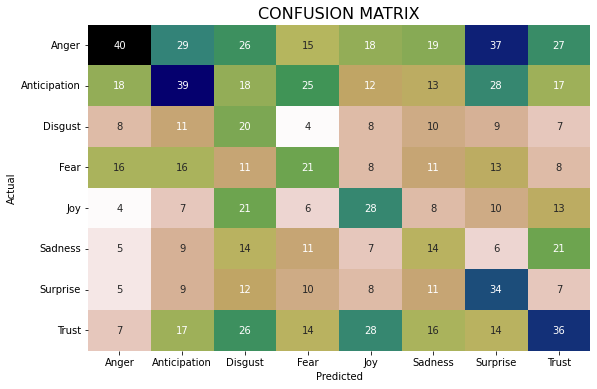

In [31]:
#Create a DTC and Adaboost Classifier
adaboost = wvmodel.adb(X_train=X_train_word_average, y_train=y_train)
data.predict(adaboost, X_test_word_average, y_test, name='adb wv')

accuracy 0.243
              precision    recall  f1-score   support

       Anger       0.39      0.25      0.30       211
Anticipation       0.33      0.25      0.28       170
     Disgust       0.14      0.23      0.17        77
        Fear       0.18      0.16      0.17       104
         Joy       0.26      0.29      0.27        97
     Sadness       0.18      0.26      0.21        87
    Surprise       0.20      0.31      0.25        96
       Trust       0.26      0.20      0.23       158

    accuracy                           0.24      1000
   macro avg       0.24      0.25      0.24      1000
weighted avg       0.27      0.24      0.25      1000



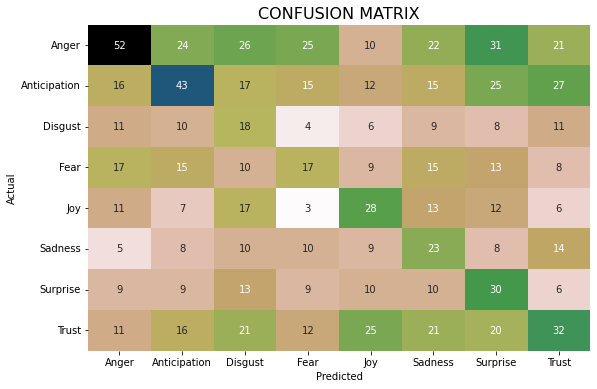

In [32]:
#Create a HGradiant Boosting Classifier
hsgb = wvmodel.hsgb(X_train=X_train_word_average, y_train=y_train)
data.predict(hsgb, X_test_word_average, y_test, name='hsgb wv')

accuracy 0.202
              precision    recall  f1-score   support

       Anger       0.26      0.26      0.26       211
Anticipation       0.24      0.21      0.23       170
     Disgust       0.06      0.12      0.08        77
        Fear       0.14      0.14      0.14       104
         Joy       0.25      0.31      0.28        97
     Sadness       0.13      0.13      0.13        87
    Surprise       0.20      0.26      0.23        96
       Trust       0.30      0.14      0.19       158

    accuracy                           0.20      1000
   macro avg       0.20      0.20      0.19      1000
weighted avg       0.22      0.20      0.20      1000



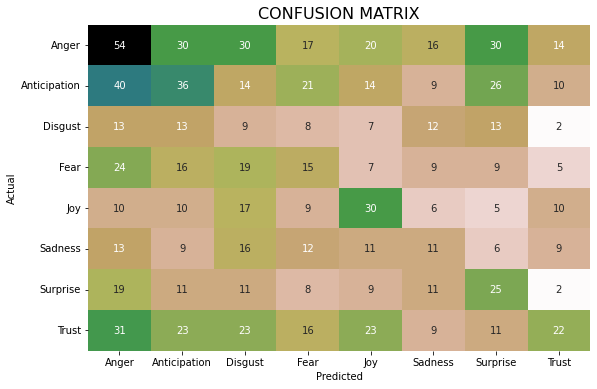

In [33]:
#KNN Classifier
knnc = wvmodel.knnc(X_train=X_train_word_average, y_train=y_train)
data.predict(knnc, X_test_word_average, y_test, name='knn wv')

accuracy 0.148
              precision    recall  f1-score   support

       Anger       0.43      0.11      0.17       211
Anticipation       0.27      0.06      0.10       170
     Disgust       0.08      0.10      0.09        77
        Fear       0.00      0.00      0.00       104
         Joy       0.13      0.51      0.21        97
     Sadness       0.00      0.00      0.00        87
    Surprise       0.13      0.60      0.22        96
       Trust       0.00      0.00      0.00       158

    accuracy                           0.15      1000
   macro avg       0.13      0.17      0.10      1000
weighted avg       0.17      0.15      0.10      1000



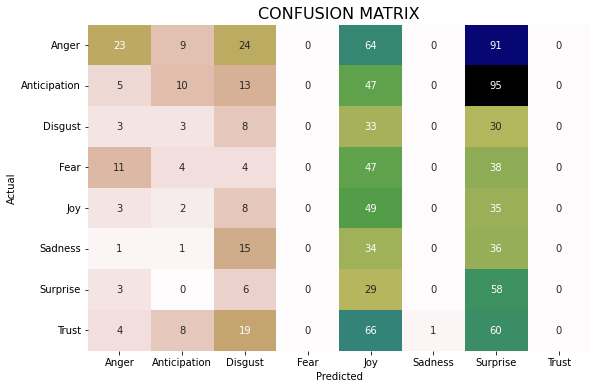

In [34]:
#SVC Classifier
svcwvl = wvmodel.svc(X_train=X_train_word_average, y_train=y_train, kernel='linear')
data.predict(svcwvl, X_test_word_average, y_test, name='svc wv l')

accuracy 0.118
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00       211
Anticipation       0.24      0.04      0.06       170
     Disgust       0.06      0.03      0.04        77
        Fear       0.00      0.00      0.00       104
         Joy       0.11      0.85      0.19        97
     Sadness       0.00      0.00      0.00        87
    Surprise       0.15      0.29      0.20        96
       Trust       0.00      0.00      0.00       158

    accuracy                           0.12      1000
   macro avg       0.07      0.15      0.06      1000
weighted avg       0.07      0.12      0.05      1000



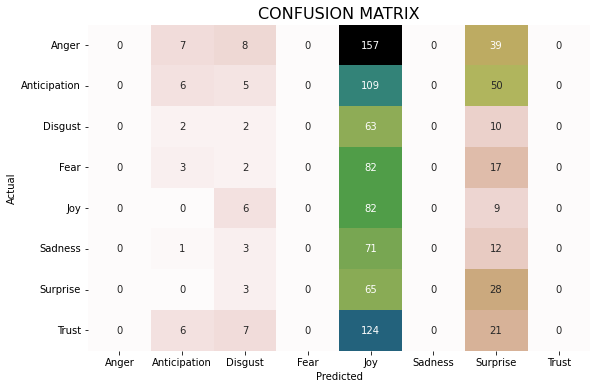

In [35]:
#SVC Classifier
svcwvp = wvmodel.svc(X_train=X_train_word_average, y_train=y_train, kernel='poly')
data.predict(svcwvp, X_test_word_average, y_test, name='svc wv p')

accuracy 0.104
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00       211
Anticipation       0.22      0.03      0.05       170
     Disgust       0.00      0.00      0.00        77
        Fear       0.00      0.00      0.00       104
         Joy       0.10      1.00      0.19        97
     Sadness       0.00      0.00      0.00        87
    Surprise       0.06      0.02      0.03        96
       Trust       0.00      0.00      0.00       158

    accuracy                           0.10      1000
   macro avg       0.05      0.13      0.03      1000
weighted avg       0.05      0.10      0.03      1000



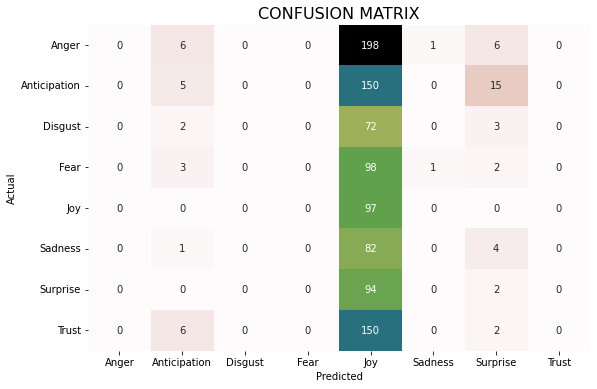

In [36]:
#SVC Classifier
svcwvs = wvmodel.svc(X_train=X_train_word_average, y_train=y_train, kernel='sigmoid')
data.predict(svcwvs, X_test_word_average, y_test, name='svc wv s')

accuracy 0.241
              precision    recall  f1-score   support

       Anger       0.41      0.22      0.29       211
Anticipation       0.35      0.24      0.29       170
     Disgust       0.12      0.22      0.16        77
        Fear       0.15      0.12      0.14       104
         Joy       0.27      0.36      0.31        97
     Sadness       0.16      0.26      0.20        87
    Surprise       0.22      0.36      0.28        96
       Trust       0.27      0.20      0.23       158

    accuracy                           0.24      1000
   macro avg       0.24      0.25      0.23      1000
weighted avg       0.28      0.24      0.24      1000



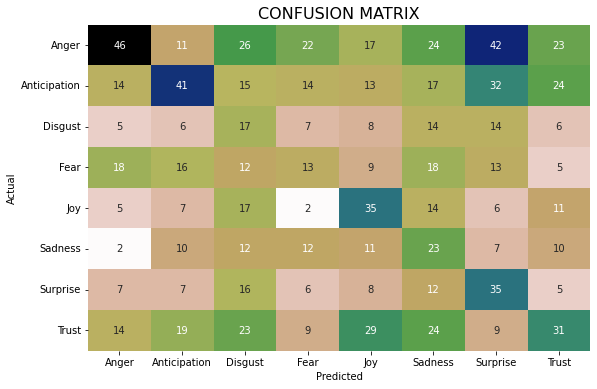

In [37]:
#RandomForest Classifier
rfc = wvmodel.rf(X_train=X_train_word_average, y_train=y_train)
data.predict(rfc, X_test_word_average, y_test, name='rff wv')

In [38]:
#Print Result of classifications
result = pd.DataFrame(data.result)
result.sort_values(by='accuracy', ascending=False)

,model,accuracy,f1_score
2,svm ln,0.320000,0.319604
5,sgd,0.288000,0.283251
6,NB dv,0.260500,0.256578
0,knn,0.257000,0.205981
9,svm dv ln,0.254500,0.248482
8,rfc dv,0.253625,0.244982
14,hsgb wv,0.243000,0.247837
19,rff wv,0.241000,0.244768
7,mlp dv,0.235625,0.221112
13,adb wv,0.232000,0.234834


### Testing a sample set

In [39]:
# Reading the final test data set
test_df = pd.read_csv(f'data/test_set.txt', sep = '\t')

#### Preparing data

In [40]:
# Preparing data to use svm model
test_df = data.normalise_sentence(test_df)
X_test_data = test_df['sentence']

In [41]:
# If using Word2Vec model
test_df_d2v = test_df.apply(lambda t: TaggedDocument(words=dtov.tokenize_text(t['clean_sentence']),tags=tags), axis=1)
X_d2v, y_d2v = dtov.splitdataset(test_df_d2v)

In [42]:
# If using Word2Vec model
test_tokenzied_wv = wvmodel.tokenize_text(test_df)
X_word_average = wvmodel.x_average(test_tokenzied_wv)

  0%|          | 0/2000 [00:00<?, ?it/s]

#### Predict data

In [43]:
# Pass the model and x dataset
pred = data.text_predict(svcmodell, X_test_data)

0it [00:00, ?it/s]

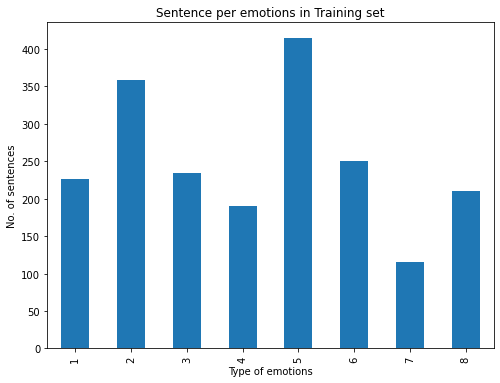

In [44]:
data.plot_distribution(pred)

In [45]:
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
pred

,sentence,emotion,definition
0,"Come , let's go get that automobile .",2,Anticipation
1,"Well , some other time , then ?",5,Joy
2,He's in trouble . Boy ?,4,Fear
3,Criminal gang unit to take control .,3,Disgust
4,By Molto . No discussion . Interview .,4,Fear
5,I was coming down the steps and there was the watchman lying dead at my feet .,4,Fear
6,"I feel rather sorry for him , don't you ?",6,Sadness
7,Now I just drink like an Irish person .,5,Joy
8,Just wait and see .,2,Anticipation
9,Any friend of [PERSON]'s is a friend of mine .,8,Trust
